<h1 style="font-size:40px;"><center>Exercise III:<br> Image Segmentation using CNNs
</center></h1>

## Short summary
In this exercise, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique color. The current folder has **three files**: 
- **configSegmenter.py:** this involves definitions of all parameters and data paths
- **utilsSegmenter.py:** includes utility functions required to grab and visualize data 
- **runSegmenter.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras. The very same environment used in Exercise II can be used here as well.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth segmentation images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a CNN model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution |
| 5 | Data | Needed | Data augementation |
| 6 | Data | Needed | Generating the data batches |
| 7 | Debug | Needed | Debugging the data |
| 8 | Device | Needed | Selecting CPU/GPU |
| 9 | Optimization | Exercise 2 | Selecting an optimization method |
| 10 | Training | Exercise 2 | Training the model   |
| 11 | Testing | Exercise 2| Testing the  method   | 
| 13 | Plotting | Information  | View some of test samples |
| 13 | Saving | Information  | Saving the model|


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.
  

1) We first start with importing all required modules

In [220]:
from tensorflow.compat.v1 import ConfigProto
import os
from configSegmenter import *

##etting GPUS before importing tensorflow to make sure it loads on the right one
cfg = flying_objects_config()
if cfg.GPU >=0:
    print("creating network model using gpu " + str(cfg.GPU))
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
elif cfg.GPU >=-1:
    print("creating network model using cpu ")
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


import tensorflow as tf
from tensorflow import keras
from utilsSegmenter import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
import os
import pprint


# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input,  Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout


creating network model using gpu 0


2) Here, we have the network model class definition. In this class, the most important function is the one called **create_model()**. As defined in the exercises section, your task is to update the network architecture defined in this function such that the network will return the highest accuracy for the given training, validation, and testing data.

In [221]:
 class SegmenterDNNModel():
    def __init__(self, num_classes=10, batch_size=32, inputShape=(64,64,3), dropout_prob=0.25):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

    def conv2d_block(self, input_tensor, n_filters, kernel_size=3, batchnorm=True):
        # first layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(input_tensor)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
                   padding="same")(x)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x

    def create_model(self):
        
        inputs = Input(shape=self.inputShape)
        
        activation_fun = 'relu'
        down1 = Conv2D(16,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(inputs)
        down1 = Conv2D(16,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(down1)
        down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
        
        down2 = Conv2D(32,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(down1_pool)
        down2 = Conv2D(32,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(down2)
        drop2 = Dropout(0.2)(down2)
        down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(drop2)
        
        down3 = Conv2D(64,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(down2_pool)
        down3 = Conv2D(64,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(down3)
        drop3 = Dropout(0.2)(down3)
        up4_pool = UpSampling2D((2, 2))(drop3)
        
        up4 = Conv2D(32,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(up4_pool)
        merge4 = concatenate([drop2,up4],axis=3)
        up4 = Conv2D(32,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(merge4)
        up4 = Conv2D(32,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(up4)
        
        up5_pool = UpSampling2D((2, 2))(up4)
        up5 = Conv2D(16,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(up5_pool)
        merge5 = concatenate([down1,up5],axis=3)
        up5 = Conv2D(16,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(merge5)
        up5 = Conv2D(16,(3,3),padding='same',activation=activation_fun, kernel_initializer="he_normal")(up5)
        

        classify = Conv2D(self.num_classes, (1, 1), activation='sigmoid')(up5)

        model = Model(inputs=inputs, outputs=classify)
        model.summary()
        return model 
      

3) We import the network **hyperparameters** and build a simple cnn by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configClassifier.py.**. Do not forget to restart kernels. 

In [222]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = SegmenterDNNModel(num_classes=cfg.NUM_CLASS, batch_size=cfg.BATCH_SIZE, inputShape=image_shape, dropout_prob=cfg.DROPOUT_PROB)
model = modelObj.create_model()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_247 (Conv2D)             (None, 128, 128, 16) 448         input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_248 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_247[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_38 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_248[0][0]                 
______________________________________________________________________________________

4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [223]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class square 	 3488 images
class triangle 	 3703 images
class circular 	 3626 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class circular 	 713 images
class square 	 783 images
class triangle 	 745 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We **augment** the data by flipping the image horizontally or vertically. As described in the exercises section below, one of your tasks is to update this data augmentation part in order to increase the network efficiency.

In [224]:
# setup data
if cfg.DATA_AUGMENTATION:
    print("Data is being augmented!")
    aug_parameters = ImageDataGenerator(
        # zoom_range=0.2, # randomly zoom into images
         #rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
         #width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
         #height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
else:
    print("Data will not be augmented!")
    aug_parameters = ImageDataGenerator(
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

Data is being augmented!


6) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [225]:
nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_segmentation_batches(cfg.training_data_dir, image_shape, cfg.BATCH_SIZE)
valid_batch_generator = generate_segmentation_batches(cfg.validation_data_dir, image_shape, cfg.BATCH_SIZE)
test_batch_generator = generate_segmentation_batches(cfg.testing_data_dir, image_shape, cfg.BATCH_SIZE)
aug_train_batch_generator = generate_augmented_segmentation_batches(train_batch_generator, aug_parameters)
aug_valid_batch_generator = generate_augmented_segmentation_batches(valid_batch_generator, aug_parameters)
print("Data batch generators are created!")

Data batch generators are created!


7) We can visualize how the data looks like for debugging purpose

x (32, 128, 128, 3) float32 0.0 1.0
y (32, 128, 128, 4) float32 0.0 1.0
x (32, 128, 128, 3) float32 0.0 1.0
y (32, 128, 128, 4) float32 0.0 1.0


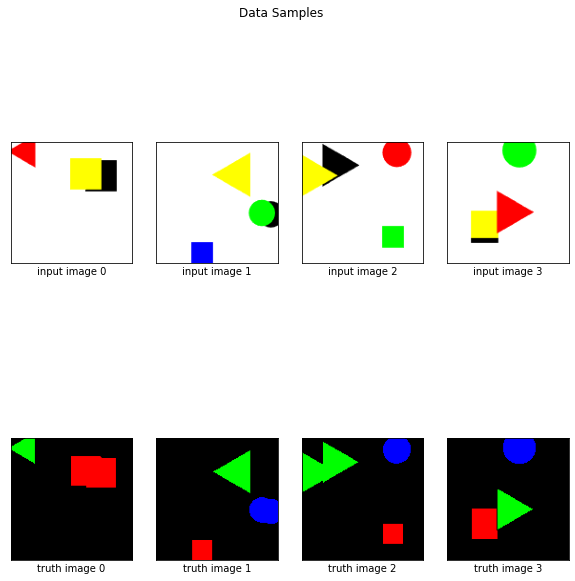

{'BATCH_SIZE': 32,
 'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'DATA_AUGMENTATION': True,
 'DEBUG_MODE': True,
 'DROPOUT_PROB': 0.5,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'LEARNING_RATE': 0.001,
 'LR_DECAY_FACTOR': 0.1,
 'NUM_CLASS': 4,
 'NUM_EPOCHS': 1,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'fineGrained': False,
 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_data_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation'}


In [226]:
if cfg.DEBUG_MODE:
    t_x, t_y = next(train_batch_generator)
    print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
    a_x, a_y = next(aug_train_batch_generator)
    print('x', a_x.shape, a_x.dtype, a_x.min(), a_x.max())
    print('y', a_y.shape, a_y.dtype, a_y.min(), a_y.max())
    plot_sample_data_with_groundtruth(a_x, a_y)
    pprint.pprint (cfg)

8) We select which processing unit to use, either CPU or GPU. In case of having multiple GPUs, we can still select which GPU to use.

9) We set the training configuration. As a part of the exercises, this function can also be updated to test different **optimization methods** such as **SGD, ADAM,** etc.

In [227]:
# Source : https://stackoverflow.com/questions/60507120/how-to-correctly-use-the-tensorflow-meaniou-metric
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [228]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
gamma = 1.5
miou = MyMeanIOU(num_classes =cfg.NUM_CLASS,name ="MeanIoU") #
opt = tf.optimizers.Adam(cfg.LEARNING_RATE*1.5)
model.compile(loss=SigmoidFocalCrossEntropy(gamma=gamma),
              optimizer= opt, metrics=[miou,'accuracy']) 

10) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configSegmenter.py.**

In [229]:
history = model.fit_generator(generator = aug_train_batch_generator,
          epochs=cfg.NUM_EPOCHS*10,
          verbose=1,
          steps_per_epoch=(nbr_train_data//cfg.BATCH_SIZE), # total batch number
          validation_steps=(nbr_valid_data // cfg.BATCH_SIZE), # total batch number
          validation_data=valid_batch_generator,
          callbacks=[TensorBoard(log_dir="logs/{}_{}".format("2_5",cfg.BATCH_SIZE), write_graph=True, write_images=False,
                                 histogram_freq=0)])

Epoch 1/10
338/338 [==============================] - 25s 75ms/step - loss: 0.0367 - MeanIoU: 0.5442 - accuracy: 0.9359 - val_loss: 0.0065 - val_MeanIoU: 0.9320 - val_accuracy: 0.9922
Epoch 2/10
338/338 [==============================] - 25s 74ms/step - loss: 0.0039 - MeanIoU: 0.9601 - accuracy: 0.9953 - val_loss: 0.0030 - val_MeanIoU: 0.9704 - val_accuracy: 0.9965
Epoch 3/10
338/338 [==============================] - 25s 74ms/step - loss: 0.0024 - MeanIoU: 0.9772 - accuracy: 0.9971 - val_loss: 0.0024 - val_MeanIoU: 0.9775 - val_accuracy: 0.9972
Epoch 4/10
338/338 [==============================] - 25s 75ms/step - loss: 0.0018 - MeanIoU: 0.9829 - accuracy: 0.9978 - val_loss: 0.0019 - val_MeanIoU: 0.9799 - val_accuracy: 0.9976
Epoch 5/10
338/338 [==============================] - 25s 75ms/step - loss: 0.0013 - MeanIoU: 0.9884 - accuracy: 0.9984 - val_loss: 0.0021 - val_MeanIoU: 0.9799 - val_accuracy: 0.9976
Epoch 6/10
338/338 [==============================] - 26s 76ms/step - loss: 0.00

11) We can test the model with the test data

In [230]:
# testing model
test_result = model.evaluate(test_batch_generator,
                                       steps=(nbr_test_data//cfg.BATCH_SIZE))
test_loss = round(test_result[0], 4)
test_IoU = round(test_result[1], 4)
test_acc = round(test_result[2],4)
print("Test Loss: ", str(test_loss),"Test Mean IoU", str(test_IoU), "Test Accuracy: ", str(test_acc))

69/69 [==============================] - 2s 29ms/step - loss: 5.1853e-04 - MeanIoU: 0.9956 - accuracy: 0.9994
Test Loss:  0.0005 Test Mean IoU 0.9956 Test Accuracy:  0.9994


12) We can also show sample segmentation results

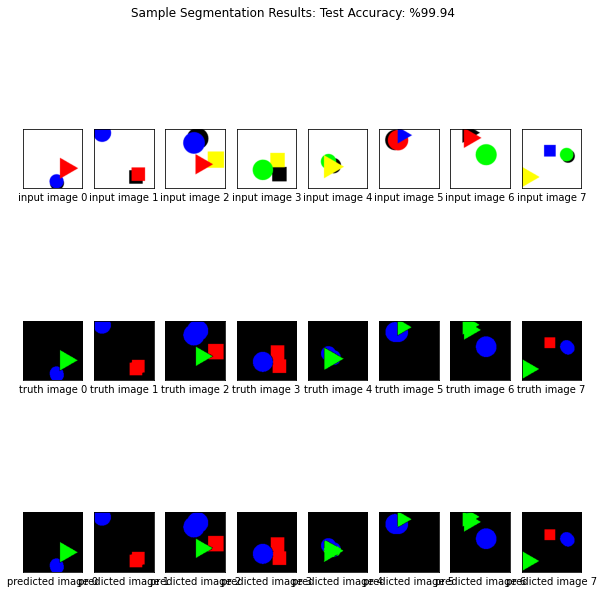

In [231]:
t_data, t_segments = next(test_batch_generator)
pred_segments = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
plot_sample_segmentation_results(t_data, t_segments, pred_segments, test_acc)

13) Finally, we can save the model

In [46]:
# save the model
model.save('./logs/model_epoch_{}.h5'.format(cfg.NUM_EPOCHS)) 

## EXERCISES

Please do all exercises desribed below. Note that all your source code as well as the log folders must be provided as final results **before May 02, 2019.** 


#### Exercise 1)
Update the network architecture given in the function **create_model** of the class SegmenterDNNModel. 

**Hint:** You can add more convolution, max pooling layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. batchnorm, dropout) methods to increase the network accuracy. Try adding more skip connections from early encoder layers to deeper decoder layers as well. 

#### Hint:
All network resposes are stored in a **log folder** which is automatically created. To visualize these responses, we can use the tensorboard as follows:
- First make sure that there is a new folder created with **a date and time stamp** under folder **logs**
- Next, open a terminal and type 
    > tensorboard --logdir=./logs
- Finally, open a web browser and type 
    > http://localhost:6006
- You can have an overview of all accuracies on the tensorboard. For more information about tensorboard, please see https://www.tensorflow.org/guide/summaries_and_tensorboard

# The report!


### Name 
Andreas Häggström 

### Introduction

### Answers to questions

#### Q1) Update the network architecture given in the function **create_model** of the class SegmenterDNNModel. 
  Based on the U-net architecture from ´´*U-Net: Convolutional Networks for Biomedical
Image Segmentation*´´ byr Ronneberger et al. (2015, https://arxiv.org/pdf/1505.04597.pdf) and a repository on github (https://github.com/zhixuhao/unet/blob/master/model.py) I constructed the following model. It is a simplified version of the U-net architecture. This architecture was developed to require less training images while still resulting in more precise segmentations. 

This version of it uses 3x3 Conv2D kernels with the relu activation. These kernels follow a channel structure of  16->32->64->32->16 in accordance with U-net. This model also uses dropout as a regularization factor.
    
            activation_fun = 'relu'
            down1 = Conv2D(16,(3,3),padding='same',activation=activation_fun)(inputs)
            down1 = Conv2D(16,(3,3),padding='same',activation=activation_fun)(down1)
            down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)

            down2 = Conv2D(32,(3,3),padding='same',activation=activation_fun)(down1_pool)
            down2 = Conv2D(32,(3,3),padding='same',activation=activation_fun)(down2)
            drop2 = Dropout(0.2)(down2)
            down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(drop2)

            down3 = Conv2D(64,(3,3),padding='same',activation=activation_fun)(down2_pool)
            down3 = Conv2D(64,(3,3),padding='same',activation=activation_fun)(down3)
            drop3 = Dropout(0.2)(down3)
            up4_pool = UpSampling2D((2, 2))(drop3)

            up4 = Conv2D(32,(3,3),padding='same',activation=activation_fun)(up4_pool)
            merge4 = concatenate([drop2,up4],axis=3)
            up4 = Conv2D(32,(3,3),padding='same',activation=activation_fun)(merge4)
            up4 = Conv2D(32,(3,3),padding='same',activation=activation_fun)(up4)

            up5_pool = UpSampling2D((2, 2))(up4)
            up5 = Conv2D(16,(3,3),padding='same',activation=activation_fun)(up5_pool)
            merge5 = concatenate([down1,up5],axis=3)
            up5 = Conv2D(16,(3,3),padding='same',activation=activation_fun)(merge5)
            up5 = Conv2D(16,(3,3),padding='same',activation=activation_fun)(up5)


            classify = Conv2D(self.num_classes, (1, 1), activation='sigmoid')(up5)

            model = Model(inputs=inputs, outputs=classify)
I also added the metric Mean Intersection over Union (MeanIoU https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU) to the model. This affected the performance slightly but all models hereafter will be trained with the MeanIoU and accuracy as metrics. In the table below the results for both the initial model and the U-net model can be seen. The most notable difference is that the difference in the accuracy is 6.2% while the difference in MeanIoU is 44.78%. This is probably due to the initial model being able to classify the different classes better than it could form the segmentation areas.

| Type          | Loss          | Accuracy  | MeanIoU  |
| ------------- |:-------------:| ---------:| --------:|
| Initial model       | 0.1287        |    0.9318 | 0.4999   |
| U-net         | 0.0187        |    0.9938 | 0.9477   |

This can be explained further by using the figure below borrowed from the blog of Jeremy Jordan (Accessed 08-12-2020 https://www.jeremyjordan.me/evaluating-image-segmentation-models/). If the model in this case classifies yellow as 'person' then this model could have a high accuracy but low IoU. It can classify that there is a person there but can't distinguish the boundaries of this person. The main improvement of the U-net in this case is therefore that the model now can construct the boundaries of the objects better. The initial model also took in 107s per epoch while the U-net model only took 24s to execute. 

![alt text](images/target_truth_IoU.png "IoU")

#### Q2) Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. batchnorm, dropout) methods to increase the network accuracy.
To further improve the model I took the advice from the lab session and read the paper ´´Focal Loss for Dense Object Detection´´ by Lin et al. (2018, https://arxiv.org/pdf/1708.02002.pdf). This paper introduced a loss function based on the Cross Entropy Criterion and extends it with a factor $(1-p_{t})^{\gamma}$ resulting in $FL(p_{t}) = - (1-p_{t})^{\gamma}\log(p_{t})$ (for full definition, see section 3 of their paper).
This added factor gives the loss function an increased performance on highly imbalanced classes. According to the page on tensorflow (https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy) this is since "down-weighs well-classified examples and focuses on hard examples". Meaning that the loss is much smaller in comparison with Cross Entropy when a easily classified class is missclassified. 
The value $\gamma$ modulates this effect and Lin et al. found that a value of 2 was optimal in their case for $\gamma$. Below is a figure comparing different values of $\gamma$ showing both the Mean IoU and accuracy of the validation data. The different line colors are explained in the table below.

| Color                            | Gamma ($\gamma$)  |
| ---------------------------------|:-------------:    | 
| <font color='red'>Red</font>     | 1                 | 
| <font color='green'>Green</font> | 1.5               |
| <font color='blue'>Blue</font>   | 2                 | 
| Black                            | 2.5               | 


<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="images/gamma_IoU1.png" width="450">
    <br>
    <em style="color: grey">Mean Intersection over Union</em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="images/gamma_accuracy1.png" width="450">
    <br>
    <em style="color: grey">Accuracy</em>
  </p> 
</td>
</tr></table>
    
Based on this comparison I chose the value of $\gamma = 1.5$, more values were tested but didn't give any interesting result. The final result of this model can be seen in the table below. I also increased the learning rate to 0.0015 but did not change the optimization function since Adam gave the optimal solution in my case.

    
| Loss           | Accuracy  | MeanIoU  |
|:-------------: | ---------:| --------:|
| 0.0005         |    0.9994 | 0.9956   |

The useage of a focal loss function together with the increase of the learning rate increased the accuracy with 0.56% and the Mean IoU with 4.79% together with lowering the loss with 0.0182 (97.33% relatively). This means that the model now with a high certainty can both classify the objects and construct the segmentation areas around them.

### Summary